In [1]:
import os
import numpy as np
import scipy
import sys
import matplotlib.pyplot as plt

In [2]:
def plot_signals(eeg_array):
    num_samples = eeg_array.shape[0]
    num_channels = eeg_array.shape[1]

    for sample in range(num_samples):
        plt.figure()
        plt.title(f"Sample {sample}")
        for channel in range(num_channels):
            plt.plot(eeg_array[sample, channel, :], label=f"Channel {channel}")
        # plt.legend()
        plt.show()

In [3]:
def plot_sample(eeg_array, sample, ax, title=None):
    num_channels = eeg_array.shape[1]

    # Plot data on the specified subplot
    ax.plot(eeg_array[sample, :, :].T)
    ax.set_title(f"{title} - Sample {sample}")

In [4]:
def plot_signal(eeg_array, sample, channel):

    num_channels = eeg_array.shape[1]

    plt.figure()
    plt.title(f"Sample {sample}, Channel {channel}")
    plt.plot(eeg_array[sample, channel, :], label=f"Channel {channel}")
    plt.legend()
    plt.show()

In [5]:
def detect_discontinuities(eeg_array, interval=20):
    num_samples = eeg_array.shape[0]
    num_channels = eeg_array.shape[1]
    num_signals = eeg_array.shape[2]
    
    discontinuities = []

    for sample in range(num_samples):
        found_discontinuity = False
        
        for channel in range(num_channels):
            for signal in range(num_signals - interval):
                interval_values = eeg_array[sample, channel, signal:signal+interval+1]

                if np.all(interval_values == np.sort(interval_values)) or np.all(interval_values == np.sort(interval_values)[::-1]):
                    if abs(interval_values[0] - interval_values[-1]) < 50:
                        # print(interval_values)
                        # print("Indices: ", signal, signal+interval+1)
                        # plot_signal(eeg_array, sample, channel)
                        discontinuities.append((sample, channel, signal))
                        found_discontinuity = True
                        break

            if found_discontinuity:
                break

    return discontinuities

In [6]:
folder_path = '../data/dance_instr_raw/'
file_list = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.mat')]

file_list.sort()

print(file_list)

['../data/dance_instr_raw/P_1.mat', '../data/dance_instr_raw/P_10.mat', '../data/dance_instr_raw/P_2.mat', '../data/dance_instr_raw/P_3.mat', '../data/dance_instr_raw/P_4.mat', '../data/dance_instr_raw/P_5.mat', '../data/dance_instr_raw/P_9.mat', '../data/dance_instr_raw/S_1.mat', '../data/dance_instr_raw/S_10.mat', '../data/dance_instr_raw/S_2.mat', '../data/dance_instr_raw/S_3.mat', '../data/dance_instr_raw/S_4.mat', '../data/dance_instr_raw/S_5.mat', '../data/dance_instr_raw/S_9.mat']


In [7]:
discontinuous_files = []

for i, file in enumerate(file_list):
    x = scipy.io.loadmat(file)
    x = x['data']

    print(x.shape)
    
    discontinuities = detect_discontinuities(x, 50)

    if(len(discontinuities) > 0):
        print(discontinuities)
        discontinuous_files.append((file, discontinuities))


(50, 14, 750)
(37, 14, 750)
(55, 14, 750)
(54, 14, 750)
(76, 14, 750)
(58, 14, 750)
[(42, 8, 253)]
(59, 14, 750)
(70, 14, 750)
[(9, 0, 680)]
(52, 14, 750)
(59, 14, 750)
(79, 14, 750)
(61, 14, 750)
(67, 14, 750)
[(14, 0, 663), (46, 0, 135)]
(62, 14, 750)


In [8]:
print(discontinuous_files)
sum = 0
for file in discontinuous_files:
    sum += len(file[1])

print(sum)

[('../data/dance_instr_raw/P_5.mat', [(42, 8, 253)]), ('../data/dance_instr_raw/S_1.mat', [(9, 0, 680)]), ('../data/dance_instr_raw/S_5.mat', [(14, 0, 663), (46, 0, 135)])]
4


Trim off the discontinuous samples found by automatic checker

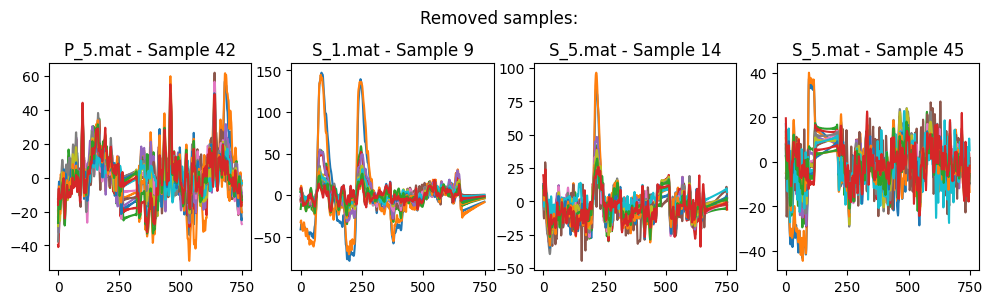

In [24]:
X = []
Y = []

num_graphs = sum
num_rows = (num_graphs + 3) // 4  # Compute the number of subplot rows

# Create a figure with subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(12, 3*num_rows))
fig.suptitle('Removed samples:')
fig.subplots_adjust(top=0.8)

subplot_index = 0

for file in file_list:
    x = scipy.io.loadmat(file)
    x = x['data']

    rmv_count = 0

    for discontinuous_file in discontinuous_files:
        if(file == discontinuous_file[0]):
            for discontinuity in discontinuous_file[1]:
                plot_sample(x, discontinuity[0] - rmv_count, axes[subplot_index % 4], title=file.split('/')[-1])
                index = discontinuity[0]
                x = np.delete(x, index-rmv_count, axis=0)
                rmv_count += 1
                subplot_index = (subplot_index + 1) % (4 * num_rows)
    
    # removethe last 250 elements from each trial
    x = x[:,:,:500]

    first_letter = file.split('/')[-1][0]

    # create output vector. If file begins with 'P', then y = [1,0], else y = [0,1], having the same dimension as x
    if first_letter == 'P':
        y = np.zeros((x.shape[0],2))
        y[:,0] = 1
    else:
        y = np.zeros((x.shape[0],2))
        y[:,1] = 1

    X.append(x)
    Y.append(y)


We now have to trim the rest of the files manually

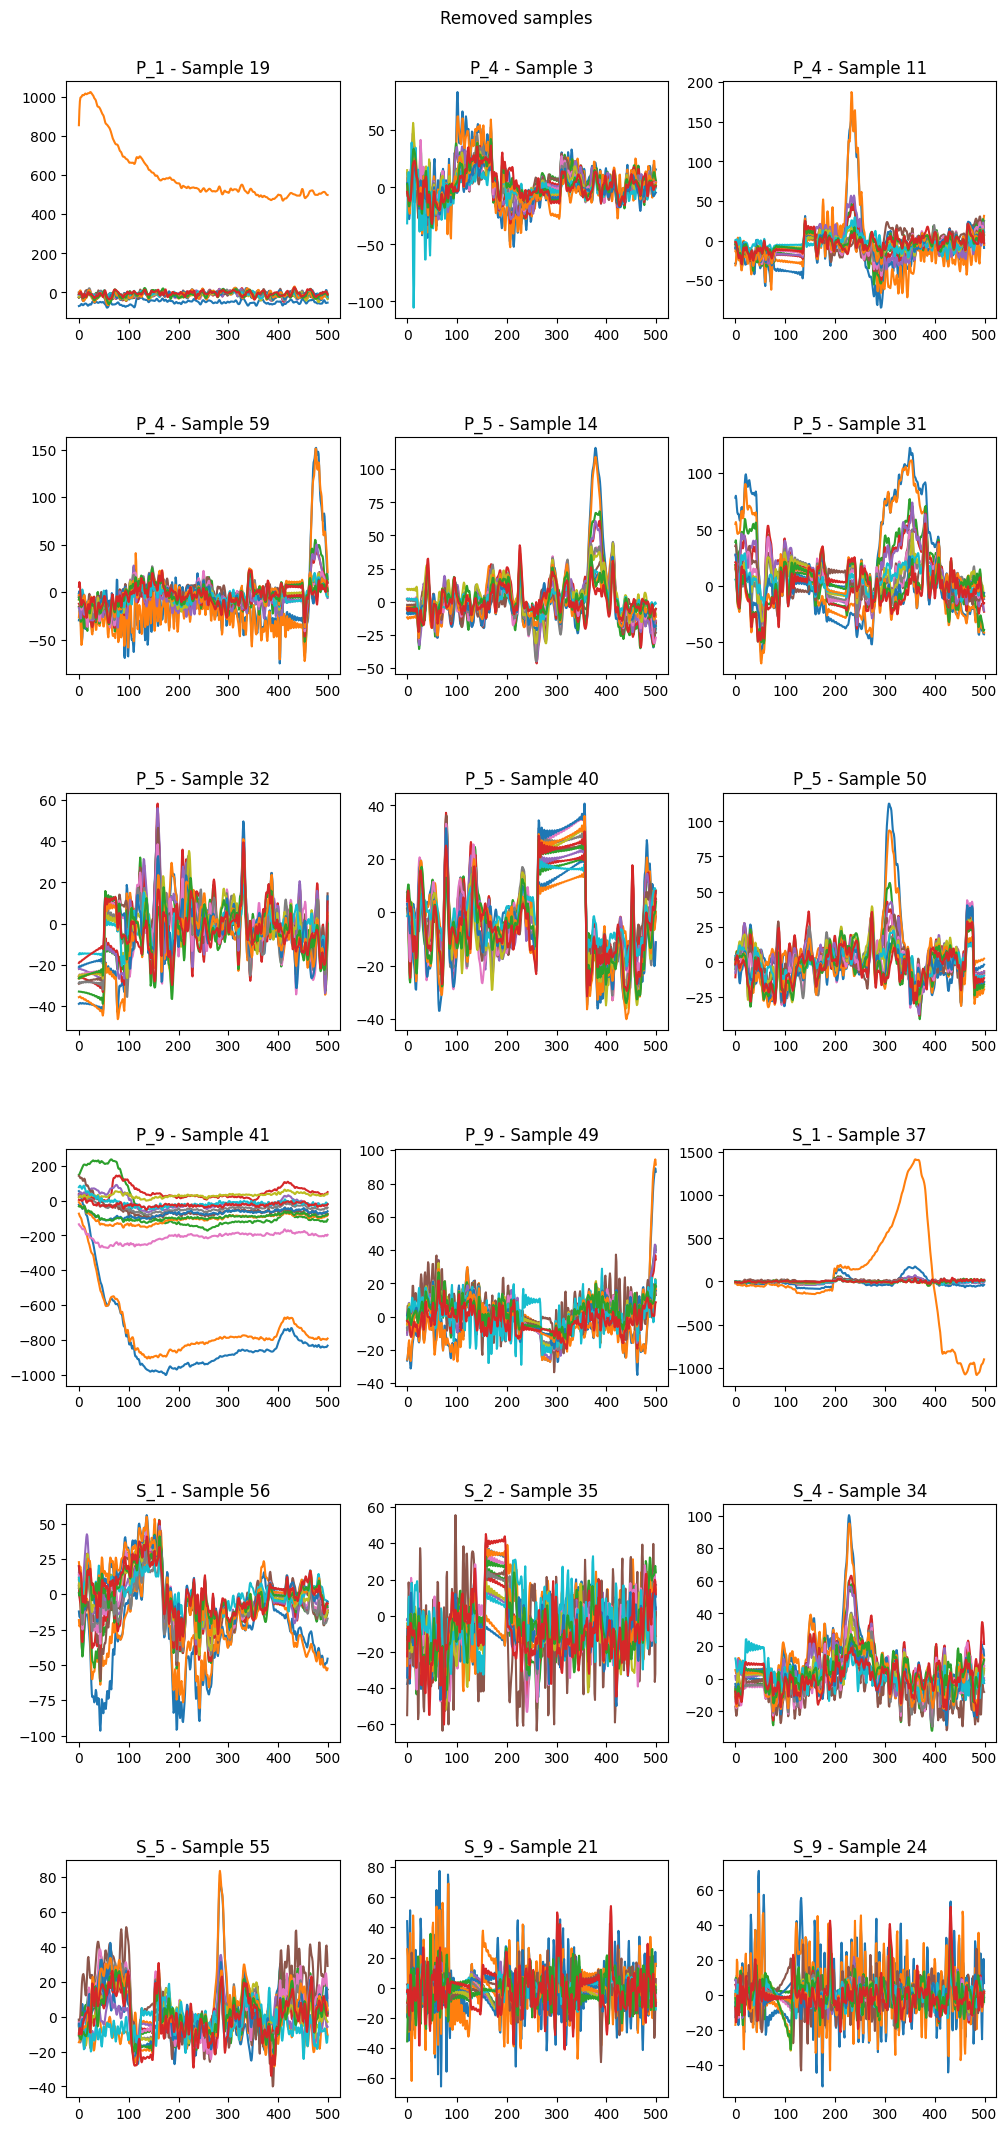

In [45]:
kick_out = [(0, [19]), (4, [3, 12, 61]), (5, [14, 32, 34, 43, 54]), (6, [41, 50]), (7, [37, 57]),
            (9, [35]), (11, [34]), (12, [55]), (13, [21, 25])]

file_dict = {0: 'P_1', 1: 'P_10', 2: 'P_2', 3: 'P_3', 4: 'P_4', 5: 'P_5', 6: 'P_9', 7: 'S_1', 8: 'S_10', 
             9: 'S_2', 10: 'S_3', 11: 'S_4', 12: 'S_5', 13: 'S_9'}

sum2 = 0
for kick in kick_out:
    sum2 += len(kick[1])

num_graphs = sum2
num_rows = (num_graphs + 2) // 3  # Compute the number of subplot rows

subplot_index = 0

# Create a figure with subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(12, 4*num_rows))
fig.subplots_adjust(top=0.95)
fig.suptitle("Removed samples")

new_X = []
new_Y = []
for i, x in enumerate(X):
    rmv_count = 0
    y = Y[i]
    for kick in kick_out:
        if i == kick[0]:
            for index in kick[1]:
                plot_sample(x, index - rmv_count, axes[subplot_index // 3, subplot_index % 3], title=file_dict[i])
                x = np.delete(x, index-rmv_count, axis=0)
                y = np.delete(y, index-rmv_count, axis=0)
                rmv_count += 1
                subplot_index = (subplot_index + 1) % (3 * num_rows)

    new_X.append(x)
    new_Y.append(y)

# Adjust the vertical spacing between subplots
plt.subplots_adjust(hspace=0.5)
    
    

In [50]:
total_elim = 0
total_samples = 0
for i, file in enumerate(file_list):
    new_x = new_X[i]
    new_y = new_Y[i]
    old_x = scipy.io.loadmat(file)['data']
    print( old_x.shape, "->", new_x.shape, new_y.shape)
    total_samples += new_x.shape[0]
    total_elim += old_x.shape[0] - new_x.shape[0]

print("Total samples removed: ", total_elim)
print("Total samples remaining: ", total_samples)

(50, 14, 750) -> (49, 14, 500) (49, 2)
(37, 14, 750) -> (37, 14, 500) (37, 2)
(55, 14, 750) -> (55, 14, 500) (55, 2)
(54, 14, 750) -> (54, 14, 500) (54, 2)
(76, 14, 750) -> (73, 14, 500) (73, 2)
(58, 14, 750) -> (52, 14, 500) (52, 2)
(59, 14, 750) -> (57, 14, 500) (57, 2)
(70, 14, 750) -> (67, 14, 500) (67, 2)
(52, 14, 750) -> (52, 14, 500) (52, 2)
(59, 14, 750) -> (58, 14, 500) (58, 2)
(79, 14, 750) -> (79, 14, 500) (79, 2)
(61, 14, 750) -> (60, 14, 500) (60, 2)
(67, 14, 750) -> (64, 14, 500) (64, 2)
(62, 14, 750) -> (60, 14, 500) (60, 2)
Total samples removed:  22
Total samples remaining:  817


In [47]:
from EEGModels import EEGNet
from tensorflow.keras import utils as np_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import balanced_accuracy_score

In [48]:
kernels, chans, samples = 1, 14, 500

Accuracies = []
p_acc = []
s_acc = []

for index_1 in range(0, 7):
    for index_2 in range(7, 14):
        # build training set from allfiles expect the ones with index_1 and index_2
        X_train = [new_X[i] for i in range(len(new_X)) if i != index_1 and i != index_2]
        Y_train = [new_Y[i] for i in range(len(new_Y)) if i != index_1 and i != index_2]

        # build test set from the files with index_1 and index_2
        X_test = [new_X[i] for i in range(len(new_X)) if i == index_1 or i == index_2]
        Y_test = [new_Y[i] for i in range(len(new_Y)) if i == index_1 or i == index_2]

        X_train = np.concatenate(X_train)
        Y_train = np.concatenate(Y_train)

        # convert data to NHWC (trials, channels, samples, kernels) format.
        X_train = X_train.reshape(X_train.shape[0], chans, samples, kernels)

        model = EEGNet(nb_classes=2, Chans=chans, Samples=samples, dropoutRate=0.5, kernLength=32, F1=8, D=2, F2=16, dropoutType='Dropout')

        # compile the model and set the optimizers
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

        # count number of parameters in the model
        numParams    = model.count_params()     

        # set a valid path for the system to record model checkpoints
        # checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1, save_best_only=True)

        class_weights = {0:1, 1:1}

        fitted_model = model.fit(X_train, Y_train, batch_size = 32, epochs = 50, verbose = 2, 
                                class_weight=class_weights)
        
        #open file to write results in
        f = open("../results/results_trimmed_capped_dance_instr_raw.txt", "a") 

        # make prediction on the 2 test files individually
        X_test_1 = X_test[0].reshape(X_test[0].shape[0], chans, samples, kernels)
        X_test_2 = X_test[1].reshape(X_test[1].shape[0], chans, samples, kernels)

        probs_1 = model.predict(X_test_1)
        probs_2 = model.predict(X_test_2)
        preds_1 = probs_1.argmax(axis = -1)
        preds_2 = probs_2.argmax(axis = -1)
        acc_1 = balanced_accuracy_score(Y_test[0].argmax(axis=-1), preds_1)
        acc_2 = balanced_accuracy_score(Y_test[1].argmax(axis=-1), preds_2)
        f.write("----------------------SELECTED FILES: %d and %d---------------------\n" % (index_1, index_2))
        f.write("Classification accuracy for P: %f \n" % (acc_1))
        f.write("Classification accuracy for S: %f \n" % (acc_2))

        p_acc.append(acc_1)
        s_acc.append(acc_2)

        # make prediction on the 2 test files together
        X_test = np.concatenate(X_test)
        X_test = X_test.reshape(X_test.shape[0], chans, samples, kernels)
        Y_test = np.concatenate(Y_test)


        probs       = model.predict(X_test)
        preds       = probs.argmax(axis = -1)
        acc         = balanced_accuracy_score(Y_test.argmax(axis=-1), preds)
        f.write("Classification accuracy for P and S: %f \n" % (acc))
        f.write("\n")

        f.close()

        Accuracies.append(acc)

print("Mean classification accuracy: %f " % (np.mean(Accuracies)))

Epoch 1/50
23/23 - 6s - loss: 0.7014 - accuracy: 0.4888 - 6s/epoch - 278ms/step
Epoch 2/50
23/23 - 4s - loss: 0.6761 - accuracy: 0.5894 - 4s/epoch - 174ms/step
Epoch 3/50
23/23 - 4s - loss: 0.6761 - accuracy: 0.6215 - 4s/epoch - 159ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6670 - accuracy: 0.6215 - 3s/epoch - 145ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6513 - accuracy: 0.6480 - 3s/epoch - 135ms/step
Epoch 6/50
23/23 - 3s - loss: 0.6475 - accuracy: 0.6592 - 3s/epoch - 145ms/step
Epoch 7/50
23/23 - 3s - loss: 0.6336 - accuracy: 0.6690 - 3s/epoch - 134ms/step
Epoch 8/50
23/23 - 3s - loss: 0.6253 - accuracy: 0.6899 - 3s/epoch - 139ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5872 - accuracy: 0.7360 - 3s/epoch - 132ms/step
Epoch 10/50
23/23 - 3s - loss: 0.5452 - accuracy: 0.7444 - 3s/epoch - 144ms/step
Epoch 11/50
23/23 - 3s - loss: 0.4990 - accuracy: 0.8073 - 3s/epoch - 131ms/step
Epoch 12/50
23/23 - 3s - loss: 0.4574 - accuracy: 0.8184 - 3s/epoch - 141ms/step
Epoch 13/50
23/23 - 3s - loss: 0.4331

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 26ms/step
Epoch 1/50
23/23 - 6s - loss: 0.7009 - accuracy: 0.5171 - 6s/epoch - 275ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6711 - accuracy: 0.5825 - 3s/epoch - 150ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6628 - accuracy: 0.6044 - 3s/epoch - 134ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6495 - accuracy: 0.6303 - 3s/epoch - 140ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6391 - accuracy: 0.6589 - 3s/epoch - 146ms/step
Epoch 6/50
23/23 - 3s - loss: 0.6354 - accuracy: 0.6658 - 3s/epoch - 141ms/step
Epoch 7/50
23/23 - 3s - loss: 0.6333 - accuracy: 0.6698 - 3s/epoch - 144ms/step
Epoch 8/50
23/23 - 3s - loss: 0.6193 - accuracy: 0.6739 - 3s/epoch - 139ms/step
Epoch 9/50
23/23 - 4s - loss: 0.6091 - accuracy: 0.6917 - 4s/epoch - 166ms/step
Epoch 10/50
23/23 - 3s - loss: 0.5978 - accuracy: 0.7094 - 3s/epoch - 138ms/step
Epoch 11/50
23/23 - 3s - loss: 0.5852 - accuracy: 0.7326 - 3s/epoch - 135ms/step
Epoch 12/50
23/23 - 3s - loss: 0.5801 - accuracy: 0.7203 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 25ms/step
Epoch 1/50
23/23 - 7s - loss: 0.7023 - accuracy: 0.5331 - 7s/epoch - 289ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6767 - accuracy: 0.6074 - 3s/epoch - 131ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6564 - accuracy: 0.6433 - 3s/epoch - 145ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6444 - accuracy: 0.6612 - 3s/epoch - 131ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6331 - accuracy: 0.6777 - 3s/epoch - 130ms/step
Epoch 6/50
23/23 - 3s - loss: 0.6342 - accuracy: 0.6818 - 3s/epoch - 125ms/step
Epoch 7/50
23/23 - 3s - loss: 0.6210 - accuracy: 0.6901 - 3s/epoch - 132ms/step
Epoch 8/50
23/23 - 3s - loss: 0.6179 - accuracy: 0.6901 - 3s/epoch - 123ms/step
Epoch 9/50
23/23 - 3s - loss: 0.6114 - accuracy: 0.6942 - 3s/epoch - 133ms/step
Epoch 10/50
23/23 - 3s - loss: 0.6038 - accuracy: 0.6928 - 3s/epoch - 124ms/step
Epoch 11/50
23/23 - 4s - loss: 0.5945 - accuracy: 0.7094 - 4s/epoch - 165ms/step
Epoch 12/50
23/23 - 4s - loss: 0.5834 - accuracy: 0.7273 - 4s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 26ms/step
Epoch 1/50
23/23 - 6s - loss: 0.7045 - accuracy: 0.5397 - 6s/epoch - 259ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6718 - accuracy: 0.6161 - 3s/epoch - 121ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6599 - accuracy: 0.6700 - 3s/epoch - 129ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6359 - accuracy: 0.6686 - 3s/epoch - 124ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6047 - accuracy: 0.7238 - 3s/epoch - 132ms/step
Epoch 6/50
23/23 - 3s - loss: 0.5619 - accuracy: 0.7620 - 3s/epoch - 125ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5540 - accuracy: 0.7479 - 3s/epoch - 128ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5093 - accuracy: 0.8130 - 3s/epoch - 124ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5004 - accuracy: 0.7975 - 3s/epoch - 127ms/step
Epoch 10/50
23/23 - 3s - loss: 0.4852 - accuracy: 0.7989 - 3s/epoch - 127ms/step
Epoch 11/50
23/23 - 3s - loss: 0.4697 - accuracy: 0.8300 - 3s/epoch - 131ms/step
Epoch 12/50
23/23 - 3s - loss: 0.4470 - accuracy: 0.8244 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


5/5 [==============================] - 0s 23ms/step
Epoch 1/50
23/23 - 6s - loss: 0.7018 - accuracy: 0.5345 - 6s/epoch - 252ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6744 - accuracy: 0.5870 - 3s/epoch - 123ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6543 - accuracy: 0.6243 - 3s/epoch - 130ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6302 - accuracy: 0.6837 - 3s/epoch - 124ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6244 - accuracy: 0.6948 - 3s/epoch - 131ms/step
Epoch 6/50
23/23 - 3s - loss: 0.6247 - accuracy: 0.6713 - 3s/epoch - 124ms/step
Epoch 7/50
23/23 - 3s - loss: 0.6140 - accuracy: 0.6920 - 3s/epoch - 128ms/step
Epoch 8/50
23/23 - 3s - loss: 0.6094 - accuracy: 0.6796 - 3s/epoch - 123ms/step
Epoch 9/50
23/23 - 4s - loss: 0.6000 - accuracy: 0.7099 - 4s/epoch - 159ms/step
Epoch 10/50
23/23 - 3s - loss: 0.5882 - accuracy: 0.7030 - 3s/epoch - 151ms/step
Epoch 11/50
23/23 - 3s - loss: 0.5666 - accuracy: 0.7279 - 3s/epoch - 147ms/step
Epoch 12/50
23/23 - 3s - loss: 0.5661 - accuracy: 0.7390 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 29ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6846 - accuracy: 0.5653 - 6s/epoch - 252ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6834 - accuracy: 0.5583 - 3s/epoch - 123ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6635 - accuracy: 0.6000 - 3s/epoch - 128ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6442 - accuracy: 0.6361 - 3s/epoch - 127ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6362 - accuracy: 0.6569 - 3s/epoch - 130ms/step
Epoch 6/50
23/23 - 3s - loss: 0.6191 - accuracy: 0.6889 - 3s/epoch - 124ms/step
Epoch 7/50
23/23 - 3s - loss: 0.6179 - accuracy: 0.6861 - 3s/epoch - 133ms/step
Epoch 8/50
23/23 - 3s - loss: 0.6027 - accuracy: 0.7111 - 3s/epoch - 125ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5586 - accuracy: 0.7444 - 3s/epoch - 131ms/step
Epoch 10/50
23/23 - 3s - loss: 0.5280 - accuracy: 0.7667 - 3s/epoch - 124ms/step
Epoch 11/50
23/23 - 3s - loss: 0.5153 - accuracy: 0.7833 - 3s/epoch - 129ms/step
Epoch 12/50
23/23 - 3s - loss: 0.4691 - accuracy: 0.8250 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 24ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6968 - accuracy: 0.5311 - 6s/epoch - 277ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6795 - accuracy: 0.5643 - 3s/epoch - 122ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6647 - accuracy: 0.6113 - 3s/epoch - 127ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6550 - accuracy: 0.6321 - 3s/epoch - 123ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6362 - accuracy: 0.6625 - 3s/epoch - 131ms/step
Epoch 6/50
23/23 - 3s - loss: 0.6233 - accuracy: 0.6846 - 3s/epoch - 121ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5970 - accuracy: 0.6860 - 3s/epoch - 129ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5769 - accuracy: 0.7275 - 3s/epoch - 121ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5721 - accuracy: 0.7151 - 3s/epoch - 128ms/step
Epoch 10/50
23/23 - 3s - loss: 0.5616 - accuracy: 0.7206 - 3s/epoch - 122ms/step
Epoch 11/50
23/23 - 3s - loss: 0.5526 - accuracy: 0.7372 - 3s/epoch - 139ms/step
Epoch 12/50
23/23 - 3s - loss: 0.5313 - accuracy: 0.7524 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 28ms/step
Epoch 1/50
23/23 - 6s - loss: 0.7107 - accuracy: 0.5322 - 6s/epoch - 250ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6746 - accuracy: 0.6091 - 3s/epoch - 122ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6544 - accuracy: 0.6447 - 3s/epoch - 131ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6434 - accuracy: 0.6502 - 3s/epoch - 125ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6173 - accuracy: 0.6708 - 3s/epoch - 128ms/step
Epoch 6/50
23/23 - 3s - loss: 0.5997 - accuracy: 0.6776 - 3s/epoch - 125ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5864 - accuracy: 0.6968 - 3s/epoch - 131ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5745 - accuracy: 0.6968 - 3s/epoch - 122ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5629 - accuracy: 0.7188 - 3s/epoch - 137ms/step
Epoch 10/50
23/23 - 3s - loss: 0.5798 - accuracy: 0.6996 - 3s/epoch - 122ms/step
Epoch 11/50
23/23 - 3s - loss: 0.5468 - accuracy: 0.7311 - 3s/epoch - 131ms/step
Epoch 12/50
23/23 - 3s - loss: 0.5387 - accuracy: 0.7160 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 23ms/step
Epoch 1/50
24/24 - 6s - loss: 0.7164 - accuracy: 0.4678 - 6s/epoch - 247ms/step
Epoch 2/50
24/24 - 3s - loss: 0.6772 - accuracy: 0.5643 - 3s/epoch - 120ms/step
Epoch 3/50
24/24 - 3s - loss: 0.6724 - accuracy: 0.5965 - 3s/epoch - 128ms/step
Epoch 4/50
24/24 - 3s - loss: 0.6584 - accuracy: 0.6206 - 3s/epoch - 120ms/step
Epoch 5/50
24/24 - 3s - loss: 0.6473 - accuracy: 0.6314 - 3s/epoch - 127ms/step
Epoch 6/50
24/24 - 3s - loss: 0.6398 - accuracy: 0.6434 - 3s/epoch - 121ms/step
Epoch 7/50
24/24 - 3s - loss: 0.6350 - accuracy: 0.6796 - 3s/epoch - 126ms/step
Epoch 8/50
24/24 - 3s - loss: 0.6204 - accuracy: 0.6716 - 3s/epoch - 121ms/step
Epoch 9/50
24/24 - 3s - loss: 0.6301 - accuracy: 0.6702 - 3s/epoch - 128ms/step
Epoch 10/50
24/24 - 3s - loss: 0.6046 - accuracy: 0.7024 - 3s/epoch - 124ms/step
Epoch 11/50
24/24 - 3s - loss: 0.5918 - accuracy: 0.7105 - 3s/epoch - 127ms/step
Epoch 12/50
24/24 - 3s - loss: 0.5708 - accuracy: 0.7399 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


3/3 [==============================] - 0s 24ms/step
Epoch 1/50
24/24 - 6s - loss: 0.6949 - accuracy: 0.5440 - 6s/epoch - 243ms/step
Epoch 2/50
24/24 - 3s - loss: 0.6769 - accuracy: 0.5778 - 3s/epoch - 123ms/step
Epoch 3/50
24/24 - 3s - loss: 0.6592 - accuracy: 0.6198 - 3s/epoch - 128ms/step
Epoch 4/50
24/24 - 3s - loss: 0.6317 - accuracy: 0.6495 - 3s/epoch - 120ms/step
Epoch 5/50
24/24 - 3s - loss: 0.5979 - accuracy: 0.6874 - 3s/epoch - 127ms/step
Epoch 6/50
24/24 - 3s - loss: 0.5553 - accuracy: 0.6982 - 3s/epoch - 132ms/step
Epoch 7/50
24/24 - 3s - loss: 0.5455 - accuracy: 0.7199 - 3s/epoch - 126ms/step
Epoch 8/50
24/24 - 3s - loss: 0.5232 - accuracy: 0.7253 - 3s/epoch - 122ms/step
Epoch 9/50
24/24 - 3s - loss: 0.5123 - accuracy: 0.7240 - 3s/epoch - 137ms/step
Epoch 10/50
24/24 - 3s - loss: 0.5398 - accuracy: 0.7131 - 3s/epoch - 131ms/step
Epoch 11/50
24/24 - 3s - loss: 0.5177 - accuracy: 0.7470 - 3s/epoch - 128ms/step
Epoch 12/50
24/24 - 3s - loss: 0.5117 - accuracy: 0.7334 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 26ms/step
Epoch 1/50
24/24 - 6s - loss: 0.7165 - accuracy: 0.4858 - 6s/epoch - 243ms/step
Epoch 2/50
24/24 - 3s - loss: 0.6731 - accuracy: 0.6119 - 3s/epoch - 132ms/step
Epoch 3/50
24/24 - 3s - loss: 0.6582 - accuracy: 0.6377 - 3s/epoch - 131ms/step
Epoch 4/50
24/24 - 3s - loss: 0.6456 - accuracy: 0.6730 - 3s/epoch - 132ms/step
Epoch 5/50
24/24 - 4s - loss: 0.6202 - accuracy: 0.6866 - 4s/epoch - 149ms/step
Epoch 6/50
24/24 - 3s - loss: 0.5973 - accuracy: 0.6974 - 3s/epoch - 126ms/step
Epoch 7/50
24/24 - 4s - loss: 0.5918 - accuracy: 0.7110 - 4s/epoch - 147ms/step
Epoch 8/50
24/24 - 3s - loss: 0.5758 - accuracy: 0.7259 - 3s/epoch - 138ms/step
Epoch 9/50
24/24 - 4s - loss: 0.5677 - accuracy: 0.7164 - 4s/epoch - 152ms/step
Epoch 10/50
24/24 - 3s - loss: 0.5602 - accuracy: 0.7354 - 3s/epoch - 120ms/step
Epoch 11/50
24/24 - 3s - loss: 0.5280 - accuracy: 0.7503 - 3s/epoch - 126ms/step
Epoch 12/50
24/24 - 3s - loss: 0.5181 - accuracy: 0.7463 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 21ms/step
Epoch 1/50
23/23 - 6s - loss: 0.7051 - accuracy: 0.5075 - 6s/epoch - 252ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6811 - accuracy: 0.5948 - 3s/epoch - 126ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6659 - accuracy: 0.6153 - 3s/epoch - 131ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6590 - accuracy: 0.6262 - 3s/epoch - 135ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6389 - accuracy: 0.6671 - 3s/epoch - 139ms/step
Epoch 6/50
23/23 - 3s - loss: 0.6290 - accuracy: 0.6944 - 3s/epoch - 140ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5943 - accuracy: 0.7258 - 3s/epoch - 135ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5619 - accuracy: 0.7340 - 3s/epoch - 136ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5483 - accuracy: 0.7176 - 3s/epoch - 138ms/step
Epoch 10/50
23/23 - 3s - loss: 0.5229 - accuracy: 0.7490 - 3s/epoch - 127ms/step
Epoch 11/50
23/23 - 3s - loss: 0.4943 - accuracy: 0.7776 - 3s/epoch - 131ms/step
Epoch 12/50
23/23 - 3s - loss: 0.4855 - accuracy: 0.7681 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 24ms/step
Epoch 1/50
23/23 - 6s - loss: 0.7146 - accuracy: 0.5176 - 6s/epoch - 255ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6797 - accuracy: 0.5626 - 3s/epoch - 127ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6688 - accuracy: 0.6006 - 3s/epoch - 133ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6584 - accuracy: 0.6399 - 3s/epoch - 129ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6454 - accuracy: 0.6596 - 3s/epoch - 134ms/step
Epoch 6/50
23/23 - 3s - loss: 0.6310 - accuracy: 0.6709 - 3s/epoch - 127ms/step
Epoch 7/50
23/23 - 3s - loss: 0.6062 - accuracy: 0.7018 - 3s/epoch - 138ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5774 - accuracy: 0.7314 - 3s/epoch - 126ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5443 - accuracy: 0.7581 - 3s/epoch - 135ms/step
Epoch 10/50
23/23 - 3s - loss: 0.5810 - accuracy: 0.7356 - 3s/epoch - 126ms/step
Epoch 11/50
23/23 - 3s - loss: 0.5425 - accuracy: 0.7567 - 3s/epoch - 131ms/step
Epoch 12/50
23/23 - 3s - loss: 0.5113 - accuracy: 0.7651 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 29ms/step
Epoch 1/50
23/23 - 6s - loss: 0.7054 - accuracy: 0.5220 - 6s/epoch - 260ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6763 - accuracy: 0.5989 - 3s/epoch - 132ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6608 - accuracy: 0.6099 - 3s/epoch - 133ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6531 - accuracy: 0.6497 - 3s/epoch - 128ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6457 - accuracy: 0.6470 - 3s/epoch - 135ms/step
Epoch 6/50
23/23 - 3s - loss: 0.6400 - accuracy: 0.6374 - 3s/epoch - 125ms/step
Epoch 7/50
23/23 - 3s - loss: 0.6262 - accuracy: 0.6731 - 3s/epoch - 133ms/step
Epoch 8/50
23/23 - 3s - loss: 0.6262 - accuracy: 0.6676 - 3s/epoch - 129ms/step
Epoch 9/50
23/23 - 3s - loss: 0.6244 - accuracy: 0.6786 - 3s/epoch - 133ms/step
Epoch 10/50
23/23 - 3s - loss: 0.6033 - accuracy: 0.6896 - 3s/epoch - 128ms/step
Epoch 11/50
23/23 - 3s - loss: 0.6012 - accuracy: 0.6978 - 3s/epoch - 133ms/step
Epoch 12/50
23/23 - 3s - loss: 0.6058 - accuracy: 0.6703 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 27ms/step
Epoch 1/50
22/22 - 7s - loss: 0.7044 - accuracy: 0.5464 - 7s/epoch - 316ms/step
Epoch 2/50
22/22 - 3s - loss: 0.6718 - accuracy: 0.5906 - 3s/epoch - 139ms/step
Epoch 3/50
22/22 - 3s - loss: 0.6673 - accuracy: 0.6106 - 3s/epoch - 144ms/step
Epoch 4/50
22/22 - 3s - loss: 0.6536 - accuracy: 0.6576 - 3s/epoch - 140ms/step
Epoch 5/50
22/22 - 3s - loss: 0.6435 - accuracy: 0.6291 - 3s/epoch - 146ms/step
Epoch 6/50
22/22 - 3s - loss: 0.6294 - accuracy: 0.6805 - 3s/epoch - 141ms/step
Epoch 7/50
22/22 - 3s - loss: 0.6191 - accuracy: 0.6890 - 3s/epoch - 145ms/step
Epoch 8/50
22/22 - 3s - loss: 0.6043 - accuracy: 0.7190 - 3s/epoch - 138ms/step
Epoch 9/50
22/22 - 3s - loss: 0.6119 - accuracy: 0.6876 - 3s/epoch - 137ms/step
Epoch 10/50
22/22 - 3s - loss: 0.5979 - accuracy: 0.7347 - 3s/epoch - 130ms/step
Epoch 11/50
22/22 - 3s - loss: 0.5842 - accuracy: 0.7461 - 3s/epoch - 132ms/step
Epoch 12/50
22/22 - 3s - loss: 0.5476 - accuracy: 0.7575 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


5/5 [==============================] - 0s 25ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6980 - accuracy: 0.5438 - 6s/epoch - 257ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6689 - accuracy: 0.6175 - 3s/epoch - 124ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6588 - accuracy: 0.6328 - 3s/epoch - 129ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6440 - accuracy: 0.6495 - 3s/epoch - 124ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6325 - accuracy: 0.6745 - 3s/epoch - 135ms/step
Epoch 6/50
23/23 - 3s - loss: 0.6250 - accuracy: 0.6787 - 3s/epoch - 122ms/step
Epoch 7/50
23/23 - 3s - loss: 0.6156 - accuracy: 0.6662 - 3s/epoch - 131ms/step
Epoch 8/50
23/23 - 3s - loss: 0.6193 - accuracy: 0.6857 - 3s/epoch - 125ms/step
Epoch 9/50
23/23 - 3s - loss: 0.6021 - accuracy: 0.6996 - 3s/epoch - 131ms/step
Epoch 10/50
23/23 - 3s - loss: 0.6127 - accuracy: 0.6829 - 3s/epoch - 125ms/step
Epoch 11/50
23/23 - 3s - loss: 0.6094 - accuracy: 0.6759 - 3s/epoch - 130ms/step
Epoch 12/50
23/23 - 3s - loss: 0.6011 - accuracy: 0.7051 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 23ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6858 - accuracy: 0.5441 - 6s/epoch - 254ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6642 - accuracy: 0.6252 - 3s/epoch - 120ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6511 - accuracy: 0.6280 - 3s/epoch - 129ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6430 - accuracy: 0.6559 - 3s/epoch - 120ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6317 - accuracy: 0.6517 - 3s/epoch - 130ms/step
Epoch 6/50
23/23 - 3s - loss: 0.6303 - accuracy: 0.6629 - 3s/epoch - 121ms/step
Epoch 7/50
23/23 - 3s - loss: 0.6300 - accuracy: 0.6629 - 3s/epoch - 127ms/step
Epoch 8/50
23/23 - 3s - loss: 0.6221 - accuracy: 0.6811 - 3s/epoch - 121ms/step
Epoch 9/50
23/23 - 3s - loss: 0.6237 - accuracy: 0.6825 - 3s/epoch - 128ms/step
Epoch 10/50
23/23 - 3s - loss: 0.6191 - accuracy: 0.6671 - 3s/epoch - 122ms/step
Epoch 11/50
23/23 - 3s - loss: 0.6088 - accuracy: 0.6881 - 3s/epoch - 127ms/step
Epoch 12/50
23/23 - 3s - loss: 0.6161 - accuracy: 0.6783 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 25ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6980 - accuracy: 0.5432 - 6s/epoch - 255ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6661 - accuracy: 0.5975 - 3s/epoch - 128ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6484 - accuracy: 0.6407 - 3s/epoch - 142ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6482 - accuracy: 0.6407 - 3s/epoch - 126ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6278 - accuracy: 0.6657 - 3s/epoch - 134ms/step
Epoch 6/50
23/23 - 3s - loss: 0.6232 - accuracy: 0.6504 - 3s/epoch - 126ms/step
Epoch 7/50
23/23 - 3s - loss: 0.6229 - accuracy: 0.6811 - 3s/epoch - 138ms/step
Epoch 8/50
23/23 - 3s - loss: 0.6185 - accuracy: 0.6699 - 3s/epoch - 129ms/step
Epoch 9/50
23/23 - 3s - loss: 0.6159 - accuracy: 0.6713 - 3s/epoch - 130ms/step
Epoch 10/50
23/23 - 3s - loss: 0.6055 - accuracy: 0.6852 - 3s/epoch - 131ms/step
Epoch 11/50
23/23 - 3s - loss: 0.5980 - accuracy: 0.7075 - 3s/epoch - 123ms/step
Epoch 12/50
23/23 - 3s - loss: 0.5859 - accuracy: 0.7201 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 27ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6992 - accuracy: 0.5463 - 6s/epoch - 250ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6734 - accuracy: 0.5969 - 3s/epoch - 123ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6520 - accuracy: 0.6320 - 3s/epoch - 130ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6475 - accuracy: 0.6489 - 3s/epoch - 124ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6318 - accuracy: 0.6657 - 3s/epoch - 134ms/step
Epoch 6/50
23/23 - 3s - loss: 0.6215 - accuracy: 0.6882 - 3s/epoch - 126ms/step
Epoch 7/50
23/23 - 3s - loss: 0.6026 - accuracy: 0.6742 - 3s/epoch - 131ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5899 - accuracy: 0.6868 - 3s/epoch - 123ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5818 - accuracy: 0.7051 - 3s/epoch - 132ms/step
Epoch 10/50
23/23 - 3s - loss: 0.5773 - accuracy: 0.6826 - 3s/epoch - 125ms/step
Epoch 11/50
23/23 - 3s - loss: 0.5401 - accuracy: 0.7388 - 3s/epoch - 129ms/step
Epoch 12/50
23/23 - 3s - loss: 0.5291 - accuracy: 0.7346 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 28ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6950 - accuracy: 0.5460 - 6s/epoch - 261ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6623 - accuracy: 0.6392 - 3s/epoch - 129ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6442 - accuracy: 0.6708 - 3s/epoch - 136ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6318 - accuracy: 0.6680 - 3s/epoch - 126ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6112 - accuracy: 0.7092 - 3s/epoch - 136ms/step
Epoch 6/50
23/23 - 3s - loss: 0.6070 - accuracy: 0.7202 - 3s/epoch - 127ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5885 - accuracy: 0.7202 - 3s/epoch - 134ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5486 - accuracy: 0.7503 - 3s/epoch - 124ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5409 - accuracy: 0.7627 - 3s/epoch - 133ms/step
Epoch 10/50
23/23 - 3s - loss: 0.4987 - accuracy: 0.7723 - 3s/epoch - 127ms/step
Epoch 11/50
23/23 - 3s - loss: 0.4798 - accuracy: 0.8093 - 3s/epoch - 134ms/step
Epoch 12/50
23/23 - 3s - loss: 0.4585 - accuracy: 0.8011 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 27ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6901 - accuracy: 0.6094 - 6s/epoch - 253ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6256 - accuracy: 0.7258 - 3s/epoch - 126ms/step
Epoch 3/50
23/23 - 3s - loss: 0.5815 - accuracy: 0.7078 - 3s/epoch - 136ms/step
Epoch 4/50
23/23 - 3s - loss: 0.5547 - accuracy: 0.7271 - 3s/epoch - 126ms/step
Epoch 5/50
23/23 - 3s - loss: 0.5416 - accuracy: 0.7230 - 3s/epoch - 132ms/step
Epoch 6/50
23/23 - 3s - loss: 0.5184 - accuracy: 0.7618 - 3s/epoch - 124ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5151 - accuracy: 0.7368 - 3s/epoch - 131ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5031 - accuracy: 0.7576 - 3s/epoch - 125ms/step
Epoch 9/50
23/23 - 3s - loss: 0.4864 - accuracy: 0.7687 - 3s/epoch - 132ms/step
Epoch 10/50
23/23 - 3s - loss: 0.4800 - accuracy: 0.7632 - 3s/epoch - 127ms/step
Epoch 11/50
23/23 - 3s - loss: 0.4796 - accuracy: 0.7839 - 3s/epoch - 131ms/step
Epoch 12/50
23/23 - 3s - loss: 0.4532 - accuracy: 0.7742 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 25ms/step
Epoch 1/50
22/22 - 6s - loss: 0.6943 - accuracy: 0.5527 - 6s/epoch - 261ms/step
Epoch 2/50
22/22 - 3s - loss: 0.6557 - accuracy: 0.6538 - 3s/epoch - 133ms/step
Epoch 3/50
22/22 - 3s - loss: 0.6396 - accuracy: 0.6510 - 3s/epoch - 135ms/step
Epoch 4/50
22/22 - 3s - loss: 0.6260 - accuracy: 0.6823 - 3s/epoch - 125ms/step
Epoch 5/50
22/22 - 3s - loss: 0.6007 - accuracy: 0.7137 - 3s/epoch - 141ms/step
Epoch 6/50
22/22 - 3s - loss: 0.5918 - accuracy: 0.7137 - 3s/epoch - 124ms/step
Epoch 7/50
22/22 - 3s - loss: 0.6036 - accuracy: 0.7094 - 3s/epoch - 130ms/step
Epoch 8/50
22/22 - 3s - loss: 0.5840 - accuracy: 0.7279 - 3s/epoch - 126ms/step
Epoch 9/50
22/22 - 3s - loss: 0.5773 - accuracy: 0.7236 - 3s/epoch - 131ms/step
Epoch 10/50
22/22 - 3s - loss: 0.5854 - accuracy: 0.7023 - 3s/epoch - 125ms/step
Epoch 11/50
22/22 - 3s - loss: 0.5853 - accuracy: 0.6923 - 3s/epoch - 131ms/step
Epoch 12/50
22/22 - 3s - loss: 0.5621 - accuracy: 0.7165 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


5/5 [==============================] - 0s 28ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6900 - accuracy: 0.5514 - 6s/epoch - 247ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6647 - accuracy: 0.6167 - 3s/epoch - 121ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6366 - accuracy: 0.6639 - 3s/epoch - 129ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6014 - accuracy: 0.6875 - 3s/epoch - 130ms/step
Epoch 5/50
23/23 - 3s - loss: 0.5536 - accuracy: 0.7194 - 3s/epoch - 130ms/step
Epoch 6/50
23/23 - 3s - loss: 0.5356 - accuracy: 0.7431 - 3s/epoch - 123ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5300 - accuracy: 0.7361 - 3s/epoch - 130ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5241 - accuracy: 0.7556 - 3s/epoch - 122ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5390 - accuracy: 0.7500 - 3s/epoch - 127ms/step
Epoch 10/50
23/23 - 3s - loss: 0.4867 - accuracy: 0.7764 - 3s/epoch - 123ms/step
Epoch 11/50
23/23 - 3s - loss: 0.4613 - accuracy: 0.7819 - 3s/epoch - 131ms/step
Epoch 12/50
23/23 - 3s - loss: 0.4532 - accuracy: 0.7833 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 39ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6976 - accuracy: 0.5391 - 6s/epoch - 252ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6855 - accuracy: 0.5559 - 3s/epoch - 131ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6669 - accuracy: 0.6075 - 3s/epoch - 122ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6577 - accuracy: 0.6075 - 3s/epoch - 130ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6523 - accuracy: 0.6411 - 3s/epoch - 130ms/step
Epoch 6/50
23/23 - 3s - loss: 0.6380 - accuracy: 0.6704 - 3s/epoch - 127ms/step
Epoch 7/50
23/23 - 3s - loss: 0.6181 - accuracy: 0.6927 - 3s/epoch - 121ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5991 - accuracy: 0.7081 - 3s/epoch - 128ms/step
Epoch 9/50
23/23 - 3s - loss: 0.6019 - accuracy: 0.7081 - 3s/epoch - 121ms/step
Epoch 10/50
23/23 - 3s - loss: 0.6035 - accuracy: 0.6913 - 3s/epoch - 130ms/step
Epoch 11/50
23/23 - 3s - loss: 0.5831 - accuracy: 0.7067 - 3s/epoch - 119ms/step
Epoch 12/50
23/23 - 3s - loss: 0.5827 - accuracy: 0.7011 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 22ms/step
Epoch 1/50
23/23 - 7s - loss: 0.7053 - accuracy: 0.5549 - 7s/epoch - 302ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6688 - accuracy: 0.6092 - 3s/epoch - 140ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6499 - accuracy: 0.6398 - 3s/epoch - 144ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6357 - accuracy: 0.6565 - 3s/epoch - 138ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6298 - accuracy: 0.6773 - 3s/epoch - 146ms/step
Epoch 6/50
23/23 - 3s - loss: 0.6178 - accuracy: 0.6898 - 3s/epoch - 147ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5715 - accuracy: 0.7260 - 3s/epoch - 144ms/step
Epoch 8/50
23/23 - 4s - loss: 0.5526 - accuracy: 0.7246 - 4s/epoch - 158ms/step
Epoch 9/50
23/23 - 4s - loss: 0.5222 - accuracy: 0.7677 - 4s/epoch - 154ms/step
Epoch 10/50
23/23 - 4s - loss: 0.4732 - accuracy: 0.7844 - 4s/epoch - 158ms/step
Epoch 11/50
23/23 - 3s - loss: 0.4201 - accuracy: 0.8067 - 3s/epoch - 149ms/step
Epoch 12/50
23/23 - 3s - loss: 0.4004 - accuracy: 0.8526 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 30ms/step
Epoch 1/50
22/22 - 6s - loss: 0.6982 - accuracy: 0.5391 - 6s/epoch - 284ms/step
Epoch 2/50
22/22 - 3s - loss: 0.6761 - accuracy: 0.6087 - 3s/epoch - 148ms/step
Epoch 3/50
22/22 - 3s - loss: 0.6645 - accuracy: 0.6130 - 3s/epoch - 142ms/step
Epoch 4/50
22/22 - 3s - loss: 0.6441 - accuracy: 0.6652 - 3s/epoch - 148ms/step
Epoch 5/50
22/22 - 3s - loss: 0.6303 - accuracy: 0.6565 - 3s/epoch - 149ms/step
Epoch 6/50
22/22 - 3s - loss: 0.6033 - accuracy: 0.7116 - 3s/epoch - 142ms/step
Epoch 7/50
22/22 - 3s - loss: 0.5489 - accuracy: 0.7594 - 3s/epoch - 150ms/step
Epoch 8/50
22/22 - 3s - loss: 0.5137 - accuracy: 0.7783 - 3s/epoch - 148ms/step
Epoch 9/50
22/22 - 3s - loss: 0.4589 - accuracy: 0.7986 - 3s/epoch - 138ms/step
Epoch 10/50
22/22 - 3s - loss: 0.4505 - accuracy: 0.7754 - 3s/epoch - 148ms/step
Epoch 11/50
22/22 - 3s - loss: 0.3968 - accuracy: 0.8188 - 3s/epoch - 142ms/step
Epoch 12/50
22/22 - 3s - loss: 0.3341 - accuracy: 0.8841 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


5/5 [==============================] - 0s 31ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6989 - accuracy: 0.5290 - 6s/epoch - 264ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6687 - accuracy: 0.5898 - 3s/epoch - 138ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6577 - accuracy: 0.6393 - 3s/epoch - 144ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6302 - accuracy: 0.6662 - 3s/epoch - 138ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6145 - accuracy: 0.6789 - 3s/epoch - 144ms/step
Epoch 6/50
23/23 - 3s - loss: 0.5840 - accuracy: 0.6959 - 3s/epoch - 137ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5658 - accuracy: 0.7327 - 3s/epoch - 149ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5538 - accuracy: 0.7228 - 3s/epoch - 147ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5198 - accuracy: 0.7723 - 3s/epoch - 141ms/step
Epoch 10/50
23/23 - 3s - loss: 0.5147 - accuracy: 0.7313 - 3s/epoch - 138ms/step
Epoch 11/50
23/23 - 3s - loss: 0.4963 - accuracy: 0.7737 - 3s/epoch - 146ms/step
Epoch 12/50
23/23 - 3s - loss: 0.4858 - accuracy: 0.7822 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 33ms/step
Epoch 1/50
22/22 - 6s - loss: 0.6976 - accuracy: 0.5329 - 6s/epoch - 292ms/step
Epoch 2/50
22/22 - 3s - loss: 0.6737 - accuracy: 0.6057 - 3s/epoch - 139ms/step
Epoch 3/50
22/22 - 3s - loss: 0.6463 - accuracy: 0.6500 - 3s/epoch - 143ms/step
Epoch 4/50
22/22 - 3s - loss: 0.6098 - accuracy: 0.7100 - 3s/epoch - 137ms/step
Epoch 5/50
22/22 - 3s - loss: 0.5867 - accuracy: 0.7143 - 3s/epoch - 146ms/step
Epoch 6/50
22/22 - 3s - loss: 0.5495 - accuracy: 0.7543 - 3s/epoch - 137ms/step
Epoch 7/50
22/22 - 3s - loss: 0.5368 - accuracy: 0.7657 - 3s/epoch - 146ms/step
Epoch 8/50
22/22 - 3s - loss: 0.5202 - accuracy: 0.7600 - 3s/epoch - 138ms/step
Epoch 9/50
22/22 - 3s - loss: 0.5137 - accuracy: 0.7529 - 3s/epoch - 145ms/step
Epoch 10/50
22/22 - 3s - loss: 0.4874 - accuracy: 0.7614 - 3s/epoch - 142ms/step
Epoch 11/50
22/22 - 3s - loss: 0.4859 - accuracy: 0.7686 - 3s/epoch - 142ms/step
Epoch 12/50
22/22 - 3s - loss: 0.4612 - accuracy: 0.7914 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


5/5 [==============================] - 0s 27ms/step
Epoch 1/50
22/22 - 6s - loss: 0.7016 - accuracy: 0.5147 - 6s/epoch - 265ms/step
Epoch 2/50
22/22 - 3s - loss: 0.6613 - accuracy: 0.6397 - 3s/epoch - 134ms/step
Epoch 3/50
22/22 - 3s - loss: 0.6383 - accuracy: 0.6632 - 3s/epoch - 139ms/step
Epoch 4/50
22/22 - 3s - loss: 0.6182 - accuracy: 0.6941 - 3s/epoch - 139ms/step
Epoch 5/50
22/22 - 3s - loss: 0.5925 - accuracy: 0.7074 - 3s/epoch - 132ms/step
Epoch 6/50
22/22 - 3s - loss: 0.5848 - accuracy: 0.7162 - 3s/epoch - 137ms/step
Epoch 7/50
22/22 - 3s - loss: 0.5372 - accuracy: 0.7632 - 3s/epoch - 141ms/step
Epoch 8/50
22/22 - 3s - loss: 0.5343 - accuracy: 0.7368 - 3s/epoch - 131ms/step
Epoch 9/50
22/22 - 3s - loss: 0.5111 - accuracy: 0.7471 - 3s/epoch - 144ms/step
Epoch 10/50
22/22 - 3s - loss: 0.4893 - accuracy: 0.7603 - 3s/epoch - 141ms/step
Epoch 11/50
22/22 - 3s - loss: 0.4961 - accuracy: 0.7441 - 3s/epoch - 142ms/step
Epoch 12/50
22/22 - 3s - loss: 0.4829 - accuracy: 0.7750 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


5/5 [==============================] - 0s 35ms/step
Epoch 1/50
22/22 - 6s - loss: 0.6910 - accuracy: 0.5645 - 6s/epoch - 265ms/step
Epoch 2/50
22/22 - 3s - loss: 0.6516 - accuracy: 0.6246 - 3s/epoch - 131ms/step
Epoch 3/50
22/22 - 3s - loss: 0.6288 - accuracy: 0.6819 - 3s/epoch - 138ms/step
Epoch 4/50
22/22 - 3s - loss: 0.6101 - accuracy: 0.7106 - 3s/epoch - 136ms/step
Epoch 5/50
22/22 - 3s - loss: 0.5911 - accuracy: 0.7063 - 3s/epoch - 130ms/step
Epoch 6/50
22/22 - 3s - loss: 0.5731 - accuracy: 0.7221 - 3s/epoch - 138ms/step
Epoch 7/50
22/22 - 3s - loss: 0.5399 - accuracy: 0.7550 - 3s/epoch - 140ms/step
Epoch 8/50
22/22 - 3s - loss: 0.5044 - accuracy: 0.7808 - 3s/epoch - 133ms/step
Epoch 9/50
22/22 - 3s - loss: 0.4614 - accuracy: 0.8152 - 3s/epoch - 137ms/step
Epoch 10/50
22/22 - 3s - loss: 0.4223 - accuracy: 0.8266 - 3s/epoch - 140ms/step
Epoch 11/50
22/22 - 3s - loss: 0.4317 - accuracy: 0.8209 - 3s/epoch - 128ms/step
Epoch 12/50
22/22 - 3s - loss: 0.3734 - accuracy: 0.8625 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


5/5 [==============================] - 0s 29ms/step
Epoch 1/50
22/22 - 6s - loss: 0.6915 - accuracy: 0.5533 - 6s/epoch - 265ms/step
Epoch 2/50
22/22 - 3s - loss: 0.6668 - accuracy: 0.6282 - 3s/epoch - 127ms/step
Epoch 3/50
22/22 - 3s - loss: 0.6460 - accuracy: 0.6700 - 3s/epoch - 136ms/step
Epoch 4/50
22/22 - 3s - loss: 0.6192 - accuracy: 0.6744 - 3s/epoch - 129ms/step
Epoch 5/50
22/22 - 3s - loss: 0.5954 - accuracy: 0.7190 - 3s/epoch - 134ms/step
Epoch 6/50
22/22 - 3s - loss: 0.5756 - accuracy: 0.7262 - 3s/epoch - 135ms/step
Epoch 7/50
22/22 - 3s - loss: 0.5468 - accuracy: 0.7378 - 3s/epoch - 126ms/step
Epoch 8/50
22/22 - 3s - loss: 0.5306 - accuracy: 0.7435 - 3s/epoch - 133ms/step
Epoch 9/50
22/22 - 3s - loss: 0.5247 - accuracy: 0.7262 - 3s/epoch - 137ms/step
Epoch 10/50
22/22 - 3s - loss: 0.4979 - accuracy: 0.7651 - 3s/epoch - 134ms/step
Epoch 11/50
22/22 - 3s - loss: 0.5031 - accuracy: 0.7608 - 3s/epoch - 128ms/step
Epoch 12/50
22/22 - 3s - loss: 0.4711 - accuracy: 0.7968 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


5/5 [==============================] - 0s 25ms/step
Epoch 1/50
22/22 - 6s - loss: 0.6966 - accuracy: 0.5681 - 6s/epoch - 266ms/step
Epoch 2/50
22/22 - 3s - loss: 0.6686 - accuracy: 0.6227 - 3s/epoch - 129ms/step
Epoch 3/50
22/22 - 3s - loss: 0.6416 - accuracy: 0.6628 - 3s/epoch - 137ms/step
Epoch 4/50
22/22 - 3s - loss: 0.6276 - accuracy: 0.6858 - 3s/epoch - 135ms/step
Epoch 5/50
22/22 - 3s - loss: 0.6214 - accuracy: 0.6772 - 3s/epoch - 128ms/step
Epoch 6/50
22/22 - 3s - loss: 0.6018 - accuracy: 0.7001 - 3s/epoch - 137ms/step
Epoch 7/50
22/22 - 3s - loss: 0.5857 - accuracy: 0.6872 - 3s/epoch - 135ms/step
Epoch 8/50
22/22 - 3s - loss: 0.5757 - accuracy: 0.7088 - 3s/epoch - 129ms/step
Epoch 9/50
22/22 - 3s - loss: 0.5668 - accuracy: 0.6930 - 3s/epoch - 137ms/step
Epoch 10/50
22/22 - 3s - loss: 0.5514 - accuracy: 0.7159 - 3s/epoch - 135ms/step
Epoch 11/50
22/22 - 3s - loss: 0.5499 - accuracy: 0.7288 - 3s/epoch - 136ms/step
Epoch 12/50
22/22 - 3s - loss: 0.5309 - accuracy: 0.7288 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


5/5 [==============================] - 0s 25ms/step
Epoch 1/50
23/23 - 6s - loss: 0.7008 - accuracy: 0.5162 - 6s/epoch - 258ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6670 - accuracy: 0.6164 - 3s/epoch - 131ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6679 - accuracy: 0.6502 - 3s/epoch - 132ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6532 - accuracy: 0.6629 - 3s/epoch - 129ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6485 - accuracy: 0.6559 - 3s/epoch - 128ms/step
Epoch 6/50
23/23 - 3s - loss: 0.6465 - accuracy: 0.6544 - 3s/epoch - 130ms/step
Epoch 7/50
23/23 - 3s - loss: 0.6299 - accuracy: 0.6700 - 3s/epoch - 128ms/step
Epoch 8/50
23/23 - 3s - loss: 0.6263 - accuracy: 0.6587 - 3s/epoch - 130ms/step
Epoch 9/50
23/23 - 3s - loss: 0.6166 - accuracy: 0.6968 - 3s/epoch - 131ms/step
Epoch 10/50
23/23 - 3s - loss: 0.6048 - accuracy: 0.7109 - 3s/epoch - 129ms/step
Epoch 11/50
23/23 - 3s - loss: 0.5976 - accuracy: 0.7109 - 3s/epoch - 130ms/step
Epoch 12/50
23/23 - 3s - loss: 0.5626 - accuracy: 0.7405 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 32ms/step
Epoch 1/50
23/23 - 6s - loss: 0.7102 - accuracy: 0.4931 - 6s/epoch - 251ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6839 - accuracy: 0.5634 - 3s/epoch - 135ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6709 - accuracy: 0.6033 - 3s/epoch - 132ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6647 - accuracy: 0.6364 - 3s/epoch - 129ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6578 - accuracy: 0.6267 - 3s/epoch - 131ms/step
Epoch 6/50
23/23 - 3s - loss: 0.6432 - accuracy: 0.6570 - 3s/epoch - 130ms/step
Epoch 7/50
23/23 - 3s - loss: 0.6400 - accuracy: 0.6598 - 3s/epoch - 131ms/step
Epoch 8/50
23/23 - 3s - loss: 0.6169 - accuracy: 0.6791 - 3s/epoch - 134ms/step
Epoch 9/50
23/23 - 3s - loss: 0.6049 - accuracy: 0.7121 - 3s/epoch - 139ms/step
Epoch 10/50
23/23 - 3s - loss: 0.5775 - accuracy: 0.7328 - 3s/epoch - 130ms/step
Epoch 11/50
23/23 - 3s - loss: 0.5639 - accuracy: 0.7011 - 3s/epoch - 131ms/step
Epoch 12/50
23/23 - 3s - loss: 0.5735 - accuracy: 0.7121 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 24ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6985 - accuracy: 0.5522 - 6s/epoch - 253ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6564 - accuracy: 0.6426 - 3s/epoch - 129ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6338 - accuracy: 0.6620 - 3s/epoch - 132ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6000 - accuracy: 0.7038 - 3s/epoch - 131ms/step
Epoch 5/50
23/23 - 3s - loss: 0.5674 - accuracy: 0.7163 - 3s/epoch - 129ms/step
Epoch 6/50
23/23 - 3s - loss: 0.5675 - accuracy: 0.7149 - 3s/epoch - 130ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5486 - accuracy: 0.7107 - 3s/epoch - 133ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5419 - accuracy: 0.7399 - 3s/epoch - 129ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5213 - accuracy: 0.7483 - 3s/epoch - 133ms/step
Epoch 10/50
23/23 - 3s - loss: 0.5035 - accuracy: 0.7677 - 3s/epoch - 131ms/step
Epoch 11/50
23/23 - 3s - loss: 0.4842 - accuracy: 0.7803 - 3s/epoch - 128ms/step
Epoch 12/50
23/23 - 3s - loss: 0.4984 - accuracy: 0.7622 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


5/5 [==============================] - 0s 29ms/step
Epoch 1/50
23/23 - 6s - loss: 0.7020 - accuracy: 0.5230 - 6s/epoch - 256ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6780 - accuracy: 0.5969 - 3s/epoch - 136ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6580 - accuracy: 0.6513 - 3s/epoch - 133ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6463 - accuracy: 0.6485 - 3s/epoch - 133ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6352 - accuracy: 0.6750 - 3s/epoch - 134ms/step
Epoch 6/50
23/23 - 3s - loss: 0.6176 - accuracy: 0.6862 - 3s/epoch - 135ms/step
Epoch 7/50
23/23 - 3s - loss: 0.6263 - accuracy: 0.6890 - 3s/epoch - 132ms/step
Epoch 8/50
23/23 - 3s - loss: 0.6014 - accuracy: 0.7015 - 3s/epoch - 132ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5729 - accuracy: 0.7308 - 3s/epoch - 131ms/step
Epoch 10/50
23/23 - 3s - loss: 0.5744 - accuracy: 0.7197 - 3s/epoch - 133ms/step
Epoch 11/50
23/23 - 3s - loss: 0.5175 - accuracy: 0.7629 - 3s/epoch - 137ms/step
Epoch 12/50
23/23 - 3s - loss: 0.4582 - accuracy: 0.7992 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 26ms/step
Epoch 1/50
23/23 - 6s - loss: 0.7049 - accuracy: 0.5203 - 6s/epoch - 256ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6806 - accuracy: 0.5820 - 3s/epoch - 134ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6676 - accuracy: 0.6031 - 3s/epoch - 133ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6554 - accuracy: 0.6087 - 3s/epoch - 142ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6357 - accuracy: 0.6522 - 3s/epoch - 132ms/step
Epoch 6/50
23/23 - 3s - loss: 0.6309 - accuracy: 0.6606 - 3s/epoch - 135ms/step
Epoch 7/50
23/23 - 3s - loss: 0.6122 - accuracy: 0.6690 - 3s/epoch - 131ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5980 - accuracy: 0.6816 - 3s/epoch - 136ms/step
Epoch 9/50
23/23 - 3s - loss: 0.6062 - accuracy: 0.6830 - 3s/epoch - 134ms/step
Epoch 10/50
23/23 - 3s - loss: 0.5623 - accuracy: 0.7321 - 3s/epoch - 132ms/step
Epoch 11/50
23/23 - 3s - loss: 0.5517 - accuracy: 0.7209 - 3s/epoch - 132ms/step
Epoch 12/50
23/23 - 3s - loss: 0.5411 - accuracy: 0.7433 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 28ms/step
Epoch 1/50
23/23 - 6s - loss: 0.7027 - accuracy: 0.5293 - 6s/epoch - 255ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6709 - accuracy: 0.5810 - 3s/epoch - 138ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6669 - accuracy: 0.5992 - 3s/epoch - 134ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6429 - accuracy: 0.6425 - 3s/epoch - 133ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6262 - accuracy: 0.6704 - 3s/epoch - 132ms/step
Epoch 6/50
23/23 - 3s - loss: 0.6125 - accuracy: 0.6620 - 3s/epoch - 138ms/step
Epoch 7/50
23/23 - 3s - loss: 0.6013 - accuracy: 0.6788 - 3s/epoch - 141ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5777 - accuracy: 0.6941 - 3s/epoch - 137ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5760 - accuracy: 0.7095 - 3s/epoch - 136ms/step
Epoch 10/50
23/23 - 3s - loss: 0.5497 - accuracy: 0.7221 - 3s/epoch - 133ms/step
Epoch 11/50
23/23 - 3s - loss: 0.5264 - accuracy: 0.7332 - 3s/epoch - 134ms/step
Epoch 12/50
23/23 - 3s - loss: 0.4771 - accuracy: 0.7793 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 25ms/step
Epoch 1/50
23/23 - 7s - loss: 0.6869 - accuracy: 0.5276 - 7s/epoch - 312ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6659 - accuracy: 0.6337 - 3s/epoch - 144ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6295 - accuracy: 0.6931 - 3s/epoch - 144ms/step
Epoch 4/50
23/23 - 3s - loss: 0.5968 - accuracy: 0.7129 - 3s/epoch - 144ms/step
Epoch 5/50
23/23 - 3s - loss: 0.5890 - accuracy: 0.6959 - 3s/epoch - 144ms/step
Epoch 6/50
23/23 - 3s - loss: 0.5763 - accuracy: 0.7129 - 3s/epoch - 142ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5577 - accuracy: 0.7298 - 3s/epoch - 144ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5417 - accuracy: 0.7298 - 3s/epoch - 147ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5324 - accuracy: 0.7214 - 3s/epoch - 143ms/step
Epoch 10/50
23/23 - 3s - loss: 0.5247 - accuracy: 0.7327 - 3s/epoch - 145ms/step
Epoch 11/50
23/23 - 3s - loss: 0.5157 - accuracy: 0.7397 - 3s/epoch - 144ms/step
Epoch 12/50
23/23 - 3s - loss: 0.5034 - accuracy: 0.7610 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 35ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6967 - accuracy: 0.5345 - 6s/epoch - 279ms/step
Epoch 2/50
23/23 - 4s - loss: 0.6680 - accuracy: 0.6243 - 4s/epoch - 156ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6613 - accuracy: 0.6271 - 3s/epoch - 141ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6383 - accuracy: 0.6602 - 3s/epoch - 147ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6291 - accuracy: 0.6616 - 3s/epoch - 148ms/step
Epoch 6/50
23/23 - 3s - loss: 0.6337 - accuracy: 0.6533 - 3s/epoch - 145ms/step
Epoch 7/50
23/23 - 3s - loss: 0.6217 - accuracy: 0.6671 - 3s/epoch - 145ms/step
Epoch 8/50
23/23 - 3s - loss: 0.6164 - accuracy: 0.6768 - 3s/epoch - 150ms/step
Epoch 9/50
23/23 - 3s - loss: 0.6111 - accuracy: 0.6878 - 3s/epoch - 147ms/step
Epoch 10/50
23/23 - 3s - loss: 0.5829 - accuracy: 0.7113 - 3s/epoch - 149ms/step
Epoch 11/50
23/23 - 3s - loss: 0.5700 - accuracy: 0.7334 - 3s/epoch - 146ms/step
Epoch 12/50
23/23 - 3s - loss: 0.5547 - accuracy: 0.7376 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 31ms/step
Epoch 1/50
23/23 - 7s - loss: 0.6990 - accuracy: 0.5188 - 7s/epoch - 283ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6643 - accuracy: 0.6541 - 3s/epoch - 142ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6512 - accuracy: 0.6695 - 3s/epoch - 143ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6293 - accuracy: 0.7127 - 3s/epoch - 145ms/step
Epoch 5/50
23/23 - 3s - loss: 0.5988 - accuracy: 0.7322 - 3s/epoch - 143ms/step
Epoch 6/50
23/23 - 3s - loss: 0.5620 - accuracy: 0.7238 - 3s/epoch - 142ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5337 - accuracy: 0.7294 - 3s/epoch - 141ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5133 - accuracy: 0.7434 - 3s/epoch - 145ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5052 - accuracy: 0.7490 - 3s/epoch - 143ms/step
Epoch 10/50
23/23 - 3s - loss: 0.4823 - accuracy: 0.7587 - 3s/epoch - 143ms/step
Epoch 11/50
23/23 - 3s - loss: 0.4790 - accuracy: 0.7503 - 3s/epoch - 143ms/step
Epoch 12/50
23/23 - 3s - loss: 0.4564 - accuracy: 0.7796 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 30ms/step
Epoch 1/50
22/22 - 6s - loss: 0.6971 - accuracy: 0.5495 - 6s/epoch - 274ms/step
Epoch 2/50
22/22 - 3s - loss: 0.6829 - accuracy: 0.5954 - 3s/epoch - 146ms/step
Epoch 3/50
22/22 - 3s - loss: 0.6644 - accuracy: 0.6270 - 3s/epoch - 144ms/step
Epoch 4/50
22/22 - 3s - loss: 0.6450 - accuracy: 0.6585 - 3s/epoch - 142ms/step
Epoch 5/50
22/22 - 3s - loss: 0.6303 - accuracy: 0.6772 - 3s/epoch - 142ms/step
Epoch 6/50
22/22 - 3s - loss: 0.6191 - accuracy: 0.6801 - 3s/epoch - 146ms/step
Epoch 7/50
22/22 - 3s - loss: 0.6215 - accuracy: 0.6801 - 3s/epoch - 150ms/step
Epoch 8/50
22/22 - 3s - loss: 0.6095 - accuracy: 0.6901 - 3s/epoch - 152ms/step
Epoch 9/50
22/22 - 3s - loss: 0.5893 - accuracy: 0.7317 - 3s/epoch - 133ms/step
Epoch 10/50
22/22 - 3s - loss: 0.5842 - accuracy: 0.7360 - 3s/epoch - 135ms/step
Epoch 11/50
22/22 - 3s - loss: 0.5815 - accuracy: 0.7016 - 3s/epoch - 135ms/step
Epoch 12/50
22/22 - 3s - loss: 0.5310 - accuracy: 0.7547 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


5/5 [==============================] - 0s 28ms/step
Epoch 1/50
23/23 - 6s - loss: 0.6920 - accuracy: 0.5217 - 6s/epoch - 261ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6757 - accuracy: 0.6056 - 3s/epoch - 141ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6571 - accuracy: 0.6238 - 3s/epoch - 143ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6393 - accuracy: 0.6490 - 3s/epoch - 135ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6210 - accuracy: 0.6797 - 3s/epoch - 126ms/step
Epoch 6/50
23/23 - 3s - loss: 0.6057 - accuracy: 0.7105 - 3s/epoch - 134ms/step
Epoch 7/50
23/23 - 3s - loss: 0.5811 - accuracy: 0.7105 - 3s/epoch - 143ms/step
Epoch 8/50
23/23 - 3s - loss: 0.5454 - accuracy: 0.7399 - 3s/epoch - 137ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5373 - accuracy: 0.7441 - 3s/epoch - 128ms/step
Epoch 10/50
23/23 - 3s - loss: 0.5192 - accuracy: 0.7552 - 3s/epoch - 136ms/step
Epoch 11/50
23/23 - 3s - loss: 0.5131 - accuracy: 0.7497 - 3s/epoch - 137ms/step
Epoch 12/50
23/23 - 3s - loss: 0.4816 - accuracy: 0.7720 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 24ms/step
Epoch 1/50
23/23 - 6s - loss: 0.7030 - accuracy: 0.4937 - 6s/epoch - 266ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6750 - accuracy: 0.5921 - 3s/epoch - 138ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6632 - accuracy: 0.6357 - 3s/epoch - 143ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6481 - accuracy: 0.6456 - 3s/epoch - 135ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6544 - accuracy: 0.6399 - 3s/epoch - 135ms/step
Epoch 6/50
23/23 - 3s - loss: 0.6329 - accuracy: 0.6681 - 3s/epoch - 128ms/step
Epoch 7/50
23/23 - 3s - loss: 0.6266 - accuracy: 0.6793 - 3s/epoch - 133ms/step
Epoch 8/50
23/23 - 3s - loss: 0.6202 - accuracy: 0.6793 - 3s/epoch - 135ms/step
Epoch 9/50
23/23 - 3s - loss: 0.6187 - accuracy: 0.6835 - 3s/epoch - 139ms/step
Epoch 10/50
23/23 - 3s - loss: 0.6149 - accuracy: 0.6835 - 3s/epoch - 137ms/step
Epoch 11/50
23/23 - 3s - loss: 0.6144 - accuracy: 0.6976 - 3s/epoch - 134ms/step
Epoch 12/50
23/23 - 3s - loss: 0.6108 - accuracy: 0.6962 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 29ms/step
Epoch 1/50
23/23 - 6s - loss: 0.7006 - accuracy: 0.5042 - 6s/epoch - 270ms/step
Epoch 2/50
23/23 - 3s - loss: 0.6836 - accuracy: 0.5728 - 3s/epoch - 148ms/step
Epoch 3/50
23/23 - 3s - loss: 0.6680 - accuracy: 0.5994 - 3s/epoch - 138ms/step
Epoch 4/50
23/23 - 3s - loss: 0.6547 - accuracy: 0.6289 - 3s/epoch - 142ms/step
Epoch 5/50
23/23 - 3s - loss: 0.6437 - accuracy: 0.6373 - 3s/epoch - 140ms/step
Epoch 6/50
23/23 - 3s - loss: 0.6185 - accuracy: 0.6751 - 3s/epoch - 144ms/step
Epoch 7/50
23/23 - 3s - loss: 0.6172 - accuracy: 0.6849 - 3s/epoch - 144ms/step
Epoch 8/50
23/23 - 3s - loss: 0.6049 - accuracy: 0.6723 - 3s/epoch - 141ms/step
Epoch 9/50
23/23 - 3s - loss: 0.5709 - accuracy: 0.7045 - 3s/epoch - 137ms/step
Epoch 10/50
23/23 - 3s - loss: 0.5624 - accuracy: 0.6765 - 3s/epoch - 138ms/step
Epoch 11/50
23/23 - 3s - loss: 0.5578 - accuracy: 0.7003 - 3s/epoch - 136ms/step
Epoch 12/50
23/23 - 3s - loss: 0.5412 - accuracy: 0.7269 - 3s/epoc

c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
c:\Users\HTPDIR-Laptop1\eeg_net_env\Lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


4/4 [==============================] - 0s 28ms/step
Mean classification accuracy: 0.887501 


In [49]:
# calculate the mean and std of the accuracies
p_acc = np.array(p_acc)
s_acc = np.array(s_acc)
acc = np.array(Accuracies)

f = open("../results/results_trimmed_capped_dance_instr_raw.txt", "a")
f.write("Mean overall accuracy: %f \n" % (np.mean(acc)))
f.write("Std overall accuracy: %f \n" % (np.std(acc)))
f.write("Mean P accuracy: %f \n" % (np.mean(p_acc)))
f.write("Std P accuracy: %f \n" % (np.std(p_acc)))
f.write("Mean S accuracy: %f \n" % (np.mean(s_acc)))
f.write("Std S accuracy: %f \n" % (np.std(s_acc)))
f.close()
